# t-SNE Visualization of MNIST Digits Dataset

This notebook demonstrates the **t-SNE** (t-Distributed Stochastic Neighbor Embedding) algorithm for dimensionality reduction and creates an animated visualization of the clustering process.

**Reference**: Based on [O'Reilly's Illustrated Introduction to t-SNE](https://www.oreilly.com/content/an-illustrated-introduction-to-the-t-sne-algorithm/)

## Objectives

1. Load and visualize the MNIST digits dataset (1,797 images of handwritten digits)
2. Apply t-SNE to reduce dimensionality from 64D to 2D
3. Capture intermediate optimization states during gradient descent
4. Create an animated visualization showing how clusters form over time
5. Understand probability distributions and similarity matrices in t-SNE

## What is t-SNE?

t-SNE is a machine learning algorithm for visualization that:
- Reduces high-dimensional data to 2 or 3 dimensions
- Preserves local structure (similar points stay close)
- Creates visually interpretable clusters
- Works by minimizing the difference between probability distributions

---

## 1. Import Required Libraries

We need several libraries:
- **numpy, pandas, scipy**: Numerical computing and data manipulation
- **sklearn**: Machine learning (includes t-SNE implementation and datasets)
- **matplotlib, seaborn**: Data visualization
- **moviepy**: For creating animated GIFs/videos

In [1]:
import numpy as np
import pandas as pd
from scipy import linalg
from scipy.spatial.distance import squareform, pdist

import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold._t_sne import _joint_probabilities, _kl_divergence

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

import moviepy as mpy

import os
if not os.path.exists('images'):
    os.makedirs('images')


### Understanding t-SNE Internal Functions

- **`_joint_probabilities`**: Calculates similarity between points in high-dimensional space
  - Uses Gaussian distribution to measure "closeness"
  - Output: probability matrix P where P[i,j] = probability that point i picks j as neighbor

- **`_kl_divergence`**: The loss function that t-SNE minimizes
  - Measures difference between high-D and low-D probability distributions
  - Lower KL divergence = better preservation of structure

## 2. Load the Digits Dataset

The **digits dataset** contains:
- 1,797 samples of handwritten digits (0-9)
- Each image is 8×8 pixels = 64 features

In [2]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [3]:
print(len(np.unique(digits.target)))
print(np.unique(digits.target))

10
[0 1 2 3 4 5 6 7 8 9]


In [4]:
print(digits['DESCR'])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

## 3. Visualize Sample Digits


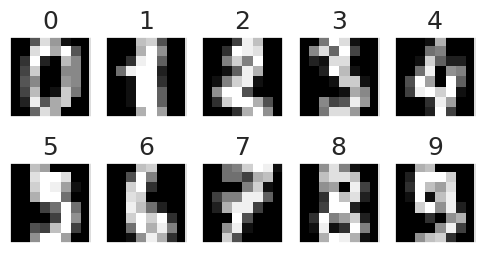

In [5]:
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
plt.gray()

for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])

plt.savefig('images/digits-generated.png', dpi=150)

## 4. Organize Data for t-SNE

We'll reorganize the data by sorting it by label (all 0s together, all 1s together, etc.).
This makes it easier to visualize cluster formation in the animation.

In [6]:
X = np.vstack([digits.data[digits.target==i] for i in range(10)])
y = np.hstack([digits.target[digits.target==i] for i in range(10)])

print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


## 5. Apply Basic t-SNE

First, let's run a standard t-SNE to see the final result.
This gives us a baseline before we create the animation.

In [7]:
digits_proj = TSNE(random_state=42).fit_transform(X)

print(digits_proj.shape)

(1797, 2)


## 6. Create Visualization Function

This function creates beautiful scatter plots with:
- Color-coded points by digit class
- Labeled cluster centers
- Clean styling

In [8]:
def scatter_df(x, colors, title="t-SNE Visualization"):
    """
    Creates a styled t-SNE scatter plot using Pandas and Seaborn.

    Parameters
    ----------
    x : ndarray
        The 2D coordinates from t-SNE.
    colors : ndarray
        The labels/targets for coloring the points.
    title : str, optional
        The title to display above the plot.

    Returns
    -------
    f, ax : matplotlib figure and axes objects.
    """
    # Prepare the DataFrame
    df = pd.DataFrame(x, columns=['x', 'y'])
    df['label'] = colors

    # Initialize the plot
    f, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    # Draw the scatter plot using Seaborn
    sns.scatterplot(
        data=df, x='x', y='y', hue='label', 
        palette='hls', legend=False, ax=ax, 
        linewidth=0, s=40
    )

    # Add the centered labels with the 'Halo' effect
    for i in df['label'].unique():
        # Get the median position for the current cluster
        xtext, ytext = df[df['label'] == i][['x', 'y']].median()
        
        txt = ax.text(xtext, ytext, str(i), fontsize=24, 
                      ha='center', va='center')
        
        # Apply the white outline for readability
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()
        ])

    ax.set_title(title, fontsize=16)
    ax.axis('off')
    ax.axis('tight')
    
    return f, ax

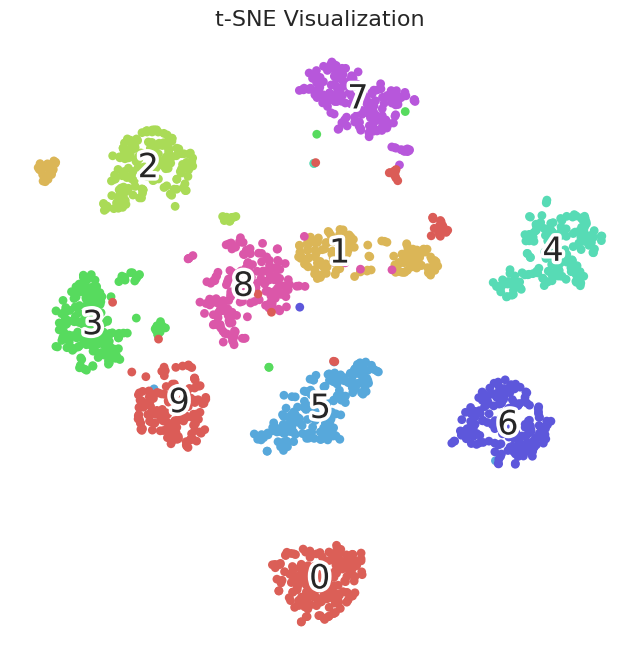

In [9]:
# Visualize the t-SNE result
scatter_df(digits_proj, y)
plt.savefig('images/tsne_basic.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Similarity Matrices

t-SNE works by:
1. Computing pairwise distances between all points
2. Converting distances to probabilities (closer points = higher probability)
3. Optimizing 2D positions to match these probabilities


In [10]:
def _joint_probabilities_constant_sigma(D, sigma):
    P = np.exp(-D**2/2 * sigma**2)
    P /= np.sum(P, axis=1)
    return P

In [11]:
# Pairwise distances between all data points.
D = pairwise_distances(X, squared=True)

# Similarity with constant sigma.
P_constant = _joint_probabilities_constant_sigma(D, .002)

# Similarity with variable sigma.
P_binary = _joint_probabilities(D, 30., False)

# The output of this function needs to be reshaped to a square matrix.
P_binary_s = squareform(P_binary)

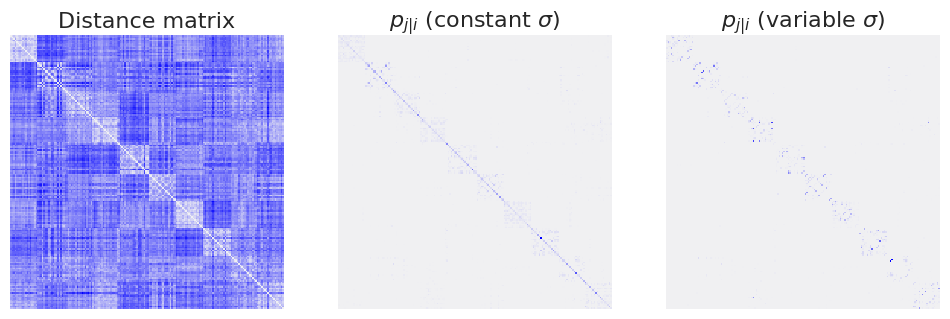

In [12]:
plt.figure(figsize=(12, 4))
pal = sns.light_palette("blue", as_cmap=True)

plt.subplot(131)
plt.imshow(D[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("Distance matrix", fontdict={'fontsize': 16})

plt.subplot(132)
plt.imshow(P_constant[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title(r"$p_{j|i}$ (constant $\sigma$)", fontdict={'fontsize': 16})

plt.subplot(133)
plt.imshow(P_binary_s[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title(r"$p_{j|i}$ (variable $\sigma$)", fontdict={'fontsize': 16})
plt.savefig('images/similarity-generated.png', dpi=120)

## 8. Custom Gradient Descent for Animation

To create an animation, we need to capture the embedding at each optimization step.

We'll "monkey-patch" sklearn's gradient descent function to:
1. Run the normal optimization
2. Save the position at each iteration in a global `positions` list
3. Return the results as normal

**Important**: This is for visualization only. For production use, stick with sklearn's default.

In [13]:
positions = []

def _gradient_descent(objective, p0, *args, **kwargs):
    """
    Optimizes an objective function using gradient descent with adaptive gains.

    This version is a wrapper designed to monkey-patch `sklearn.manifold.TSNE`. 
    It captures the intermediate coordinates of the embedding at each iteration 
    and stores them in a global `positions` list for animation purposes.

    Parameters
    ----------
    objective : callable
        The function to minimize. It should return the current error and the 
        gradient. Usually `sklearn.manifold._t_sne._kl_divergence`.
    p0 : ndarray of shape (n_params,)
        The initial point (flattened embedding) from which to start 
        the optimization.
    *args : list
        Positional arguments passed by sklearn. Typically includes `it` 
        (start iteration), `n_iter` (max iterations), and optimization data.
    **kwargs : dict
        Keyword arguments passed by sklearn. Includes hyperparameters like 
        `learning_rate`, `momentum`, and `n_iter_check`.

    Returns
    -------
    p : ndarray of shape (n_params,)
        The optimized parameters (flattened embedding).
    error : float
        The final value of the objective function (KL divergence).
    i : int
        The actual number of iterations completed.

    Notes
    -----
    This function modifies the global `positions` variable. Ensure `positions` 
    is initialized as an empty list before calling the parent t-SNE transform.
    """
    # Manually extract the iteration parameters - check positional args first, then kwargs
    it = args[0] if len(args) > 0 else kwargs.get('it', 0)
    n_iter = args[1] if len(args) > 1 else kwargs.get('n_iter', 1000)
    
    # Initialize 'i' for the return statement
    i = it

    # Extract hyperparameters
    n_iter_without_progress = kwargs.get('n_iter_without_progress', 30)
    momentum = kwargs.get('momentum', 0.5)
    learning_rate = kwargs.get('learning_rate', 1000.0)
    min_gain = kwargs.get('min_gain', 0.01)
    min_grad_norm = kwargs.get('min_grad_norm', 1e-7)
    min_error_diff = kwargs.get('min_error_diff', 1e-7)
    
    # Handle the objective arguments (P matrix, etc.). This is a separate keyword 'args'
    obj_args = kwargs.get('args', args[2:] if len(args) > 2 else [])

    # Standard optimization setup
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float64).max
    best_error = np.finfo(np.float64).max
    best_iter = 0

    # loop
    for i in range(it, n_iter):
        positions.append(p.copy()) # The recording step

        new_error, grad = objective(p, *obj_args)
        error_diff = np.abs(new_error - error)
        error = new_error
        grad_norm = linalg.norm(grad)

        if error < best_error:
            best_error = error
            best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        if min_grad_norm >= grad_norm:
            break
        if min_error_diff >= error_diff:
            break

        inc = update * grad >= 0.0
        dec = np.invert(inc)
        gains[inc] += 0.05
        gains[dec] *= 0.95
        np.clip(gains, min_gain, np.inf)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

    return p, error, i


In [14]:
# Replace sklearn's gradient descent with our custom version
sklearn.manifold._t_sne._gradient_descent = _gradient_descent

## 9. Run t-SNE and Record Intermediate States

Now we'll run t-SNE with more iterations for better cluster separation.

In [15]:
# Reset positions list
positions = []

# Run t-SNE with extended iterations
X_proj = TSNE(
    random_state=42, max_iter=5000, learning_rate=200.0, perplexity=30.0
).fit_transform(X)

In [16]:
print(f"Recorded {len(positions)} frames successfully!")

Recorded 712 frames successfully!


## 10. Prepare Data for Animation

Convert the list of positions into a 3D numpy array.

In [17]:
X_iter = np.dstack([position.reshape(-1, 2) for position in positions])
X_iter.shape

(1797, 2, 712)

We see that there are:
  - 1797 data points
  - 2 dimensions (x, y)
  - 712 frames

## 11. Create the Animation

Now we'll generate an animated GIF showing the evolution of the t-SNE embedding.


In [18]:
def mplfig_to_npimage(fig):
    """ 
    Converts a Matplotlib figure to an RGB numpy array for MoviePy.
    """
    fig.canvas.draw()
    
    # Get the memory buffer (RGBA)
    buf = fig.canvas.buffer_rgba()
    
    # Shape the data into (Height, Width, 4)
    # [::-1] flips (W, H) to (H, W) for NumPy
    h, w = fig.canvas.get_width_height()[::-1]
    img = np.frombuffer(buf, dtype=np.uint8).reshape(h, w, 4)
    
    return img[:, :, :3]

**Animation parameters**:
- `fps=20`: 20 frames per second (smooth playback)
- Duration: ~4 minutes (5000 frames ÷ 20 fps)
- Final 3 seconds: Freeze on the final resultAnimation Time

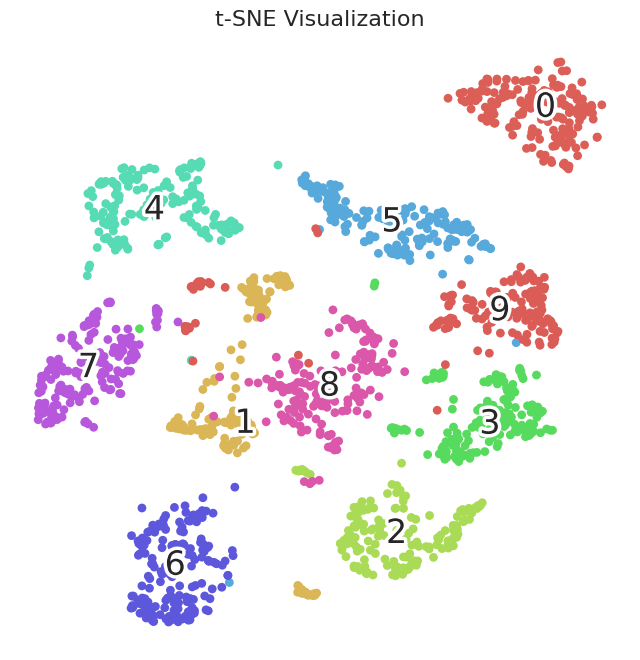

In [19]:
f, ax = scatter_df(X_proj, y)

fps = 20
data_frames = X_iter.shape[2]
data_duration = data_frames / fps
freeze_duration = 3.0 
total_duration = data_duration + freeze_duration

def make_frame(t):
    """
    Generate a single frame at time t.
    
    Args:
        t: Time in seconds
    
    Returns:
        numpy array: RGB image for this frame
    """
    if t < data_duration:
        # During animation phase - show progressive frames
        i = int(t * fps)
    else:
        # During freeze phase - show last frame
        i = data_frames - 1
    
    # Clamp to valid range
    i = min(i, data_frames - 1)
    
    # Get coordinates at this iteration
    x = X_iter[:, :, i]
    
    # Update scatter plot positions
    ax.collections[0].set_offsets(x)

    # Update label positions to cluster centers
    for text_obj in ax.texts:
        try:
            label_val = int(text_obj.get_text())
            new_median = np.median(x[y == label_val, :], axis=0)
            text_obj.set_position(new_median)
        except:
            continue
            
    return mplfig_to_npimage(f)

In [20]:
# Generate the animation
animation = mpy.VideoClip(make_frame, duration=total_duration)

# Save as GIF 
animation.write_gif("tsne_evolution.gif", fps=fps)

# Alternatively, save as MP4 
# animation.write_videofile("tsne_evolution.mp4", fps=fps)

MoviePy - Building file tsne_evolution.gif with imageio.


## 12. Similarity Matrix Evolution

We can also animate how the pairwise similarities change as the embedding evolves.

MoviePy - Building file matrix-da2d5f1b-1.gif with imageio.


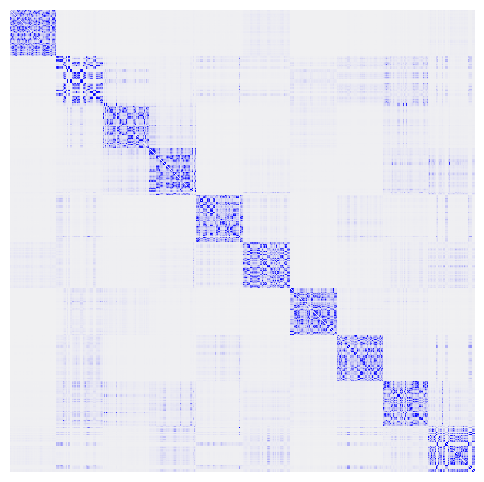

In [21]:
n = 1. / (pdist(X_iter[..., -1], "sqeuclidean") + 1)
Q = n / (2.0 * np.sum(n))
Q = squareform(Q)

f = plt.figure(figsize=(6, 6))
ax = plt.subplot(aspect='equal')
im = ax.imshow(Q, interpolation='none', cmap=pal)
plt.axis('tight')
plt.axis('off')

def make_frame_mpl(t):
    i = int(t*40)
    n = 1. / (pdist(X_iter[..., i], "sqeuclidean") + 1)
    Q = n / (2.0 * np.sum(n))
    Q = squareform(Q)
    im.set_data(Q)
    return mplfig_to_npimage(f)

animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)
animation.write_gif("matrix-da2d5f1b-1.gif", fps=20)


**Next steps**:
- Try different perplexity values (5-50)
- Experiment with learning rates
- Apply to your own datasets
- Compare with other dimensionality reduction methods (PCA, UMAP)